In [48]:
import numpy as n
import pylab as pl
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
%matplotlib inline

In [2]:
def gaussLineInt(func,xa,ya,za,xb,yb,zb):
    """
    Integrate FX(x,y,z) over the line (xa,ya,za) to (xb,yb,zb).  This
    subroutine does Gaussian integration with the first twelve Legendre
    polynomials as the basis fuctions.  Abromowitz and Stegun page 916.
    """
    
    # Positive zeros of 12th order Legendre polynomial
    a = [0.1252334085,  0.3678314989,  0.5873179542,
        0.7699026741,  0.9041172563,  0.9815606342]
    # Gaussian Integration coefficients for a 12th order polynomial
    wt = [0.2491470458,  0.2334925365,  0.2031674267,
        0.1600783285,  0.1069393259,  0.0471753363]
        
    dx = (xb-xa)/2.0
    dy = (yb-ya)/2.0
    dz = (zb-za)/2.0
    xbar = (xb+xa)/2.0
    ybar = (yb+ya)/2.0
    zbar = (zb+za)/2.0
    
    sum = 0.0
    for i in range(len(a)):
        sum = sum + wt[i] * (
                            func(xbar+a[i]*dx,ybar+a[i]*dy,zbar+a[i]*dz)+
                            func(xbar-a[i]*dx,ybar-a[i]*dy,zbar-a[i]*dz)
                            )

    return 0.5*sum 

In [3]:
def Ax(x,y,z):
    p = n.zeros_like(x)
    return p


In [4]:
def Ay(x,y,z):
    p = n.zeros_like(x)
    return p


In [5]:
def Az(x,y,z):
    Lx = 25.6
    Ly = 12.8
    p = -0.1*n.cos(2*n.pi*x/Lx)*n.cos(n.pi*y/Ly);
    return p

In [6]:
os.chdir('/Users/wiltbemj/Dropbox/Python/MHDpy/')
import MHDpy

In [7]:
# Model Parameters
NO = 8                # - default 8th order, hard coded for PDM
NO2 = NO/2            # num of ghost cells on each end
gamma=5./3.             # ratio of the specific heat, 5/3 for ideal gas
CFL = 0.3             # Courant number
PDMB= 4.0             # PDM beta parameter for controlling numerical diffusion
CA=10                 #  speed of light, normalized with VA, 
                      #    use something like 1e10 no Boris correction
limiter_type = 'PDM'  # 'PDM' - 8th order with PDM limiter
                      # 'TVD' - 2nd order with Van-Leer limiter
                      # '8th' - 8th order without limiter
                      # 'WENO'- 5th order with WENO reconstruction 
                      #         (not tested in the getEk algorithm yet)
                      # 'PPM' - 3rd order PPM method (not tested yet)
imagedir = '/Users/wiltbemj/Downloads/figs' # directory to store image files
imagebase = 'bw' # base name of image files.

In [21]:
nx = 64
ny = 32
nz = 1

(x,y,z)=MHDpy.Generate_Grid_3D_uniform(nx,ny,nz,NO) # This function generate a 
                                               # uniformly distributed active 
                                               # grid between -1 and 1 with 
                                               # nx, ny nz active cells in each 
                                               # direction
(nx_total,ny_total,nz_total)=x.shape           # with NO/2 ghost cells, 
                                               # nx_total, ny_total, nz_total 
                                               # are total num of cell corners

x = (x+1.)/1.  #map the x grid from [-1 1] to [0 2]
y = (y+0.)/1.
z = (z+0.)/1.
Lx=25.6
Ly=12.8
x=Lx/2*x
y=Ly/2*y
# Calculate grids and indices
# xc,yc,zc: cell centers
# xi,yi,zi: i-face cetners where bi is defined
# xj,yj,zj: j-face cetners where bj is defined
# xk,yk,zk: k-face cetners where bk is defined
# dx,dy,dz: lengths of each cell edge
(xc,yc,zc,xi,yi,zi,xj,yj,zj,xk,yk,zk,dx,dy,dz)=MHDpy.Metrics(x,y,z,NO)

In [78]:
# Define premitive Hydrodynamic variables at cell center
rho = n.zeros(xc.shape)
vx = n.zeros(xc.shape)
vy = n.zeros(xc.shape)
vz = n.zeros(xc.shape)
p = n.zeros(xc.shape)

# Define Magnetic fields at cell faces
bi = n.zeros(xi.shape)
bj = n.zeros(xj.shape)
bk = n.zeros(xk.shape)

# Define Electric fields at cell edges
Ei = n.zeros((nx_total-1,ny_total,nz_total))
Ej = n.zeros((nx_total,ny_total-1,nz_total))
Ek = n.zeros((nx_total,ny_total,nz_total-1))
  
# 2D OGEM Reconnection Challenge
mu0 = 4*n.pi*1e-7
epsilon0=8.85418782*1e-12
c=3e8
ech=1.60217657*1e-19
Mp = 1.67e-27 #[kg]
n0=1e16 #Density of particles per m^-3
t0 =Mp/(ech)
x0 = c*n.sqrt(epsilon0*Mp/(ech**2*n0)) #[m] 
u0 = x0/t0    #[m/s] - 100 km/
rho0=Mp*n0 # [kg/m^3] 
p0 = rho0*u0**2 #[N/m^2]
B0 = n.sqrt(mu0*rho0*u0**2) # [T]

no=1
lam=0.5
n_inf=0.2*no
Psi0=0.1

bi[NO2:-NO2+1,NO2:-NO2,NO2:-NO2] = (n.tanh(yi[NO2:-NO2+1,NO2:-NO2,NO2:-NO2]/lam)+
    (n.pi/Ly)*Psi0*n.cos(2*n.pi*xi[NO2:-NO2+1,NO2:-NO2,NO2:-NO2]/Lx)*
    n.sin(n.pi*yi[NO2:-NO2+1,NO2:-NO2,NO2:-NO2]/Ly))
bj[NO2:-NO2,NO2:-NO2+1,NO2:-NO2]=-1.0*((2*n.pi/Lx)*Psi0*
    n.sin(2*n.pi*xj[NO2:-NO2,NO2:-NO2+1,NO2:-NO2]/Lx)*
    n.cos(n.pi*yj[NO2:-NO2,NO2:-NO2+1,NO2:-NO2]/Ly))
bk[NO2:-NO2,NO2:-NO2,NO2:-NO2+1]=0
rho[NO2:-NO2,NO2:-NO2,NO2:-NO2]=(no*
    (n_inf/no+(1/(n.cosh(yc[NO2:-NO2,NO2:-NO2,NO2:-NO2]/lam)))**2))
p[NO2:-NO2,NO2:-NO2,NO2:-NO2]=0.5*(1.0/(n.cosh(yc[NO2:-NO2,NO2:-NO2,NO2:-NO2]/lam)))**2+0.2
#
# calculate bx, by, bz at cell center, 2nd order accurate, equation (36) in
# Lyon et al., [2004] (the 1/8 in Lyon et al., [2004] is actually a typo)
bx = (bi[1:,:,:] + bi[:-1,:,:])/2.
by = (bj[:,1:,:] + bj[:,:-1,:])/2.
bz = (bk[:,:,1:] + bk[:,:,:-1])/2.


In [29]:
LAi = n.zeros(x.shape)
LAj = n.zeros(x.shape)
LAk = n.zeros(x.shape)
for i in range(NO2,nx+NO2):
    xijk = x[i,NO2:-NO2+1,NO2:-NO2+1]
    xip1 = x[i+1,NO2:-NO2+1,NO2:-NO2+1]
    yijk = y[i,NO2:-NO2+1,NO2:-NO2+1]
    yip1 = y[i+1,NO2:-NO2+1,NO2:-NO2+1]
    zijk = z[i,NO2:-NO2+1,NO2:-NO2+1]
    zip1 = z[i+1,NO2:-NO2+1,NO2:-NO2+1]
    LAi[i,NO2:-NO2+1,NO2:-NO2+1]=((x[i+1,NO2:-NO2+1,NO2:-NO2+1]-
                               x[i,NO2:-NO2+1,NO2:-NO2+1])*
                              gaussLineInt(Ax,xip1,yip1,zip1,xijk,yijk,zijk))
for j in range(NO2,ny+NO2):
    xijk = x[NO2:-NO2,j,NO2:-NO2]
    xjp1 = x[NO2:-NO2,j+1,NO2:-NO2]
    yijk = y[NO2:-NO2,j,NO2:-NO2]
    yjp1 = y[NO2:-NO2,j+1,NO2:-NO2]
    zijk = z[NO2:-NO2,j,NO2:-NO2]
    zjp1 = z[NO2:-NO2,j+1,NO2:-NO2]
    LAj[NO2:-NO2,j,NO2:-NO2]=((y[NO2:-NO2,j+1,NO2:-NO2]-
                               y[NO2:-NO2,j,NO2:-NO2])*
                              gaussLineInt(Ay,xjp1,yjp1,zjp1,xijk,yijk,zijk))    
for k in range(NO2,nz+NO2):
    xijk = x[NO2:-NO2,NO2:-NO2,k]
    xkp1 = x[NO2:-NO2,NO2:-NO2,k+1]
    yijk = y[NO2:-NO2,NO2:-NO2,k]
    ykp1 = y[NO2:-NO2,NO2:-NO2,k+1]
    zijk = z[NO2:-NO2,NO2:-NO2,k]
    zkp1 = z[NO2:-NO2,NO2:-NO2,k+1]
    LAk[NO2:-NO2,NO2:-NO2,k]=((z[NO2:-NO2,NO2:-NO2,k+1]-
                               z[NO2:-NO2,NO2:-NO2,k])*
                              gaussLineInt(Az,xkp1,ykp1,zkp1,xijk,yijk,zijk))

In [32]:
biFromA = n.zeros(xi.shape)
bjFromA = n.zeros(xj.shape)
bkFromA = n.zeros(xk.shape)

In [67]:
biFromA[NO2:-NO2+1,NO2:-NO2,NO2:-NO2] = (LAj[NO2:-NO2+1,NO2:-NO2-1,NO2:-NO2-1] - 
                                         LAj[NO2:-NO2+1,NO2:-NO2-1,NO2+1:-NO2] +
                                         LAk[NO2:-NO2+1,NO2+1:-NO2,NO2:-NO2-1] -
                                         LAk[NO2:-NO2+1,NO2:-NO2-1,NO2:-NO2-1])
bjFromA[NO2:-NO2:,NO2:-NO2+1,NO2:-NO2] = -(LAi[NO2:-NO2-1,NO2:-NO2+1,NO2:-NO2-1] -
                                           LAi[NO2:-NO2-1,NO2:-NO2+1,NO2+1:-NO2] +
                                           LAk[NO2+1:-NO2,NO2:-NO2+1,NO2:-NO2-1] -
                                           LAk[NO2:-NO2-1,NO2:-NO2+1,NO2:-NO2-1])
bkFromA[NO2:-NO2:,NO2:-NO2,NO2:-NO2+1] = (LAi[NO2:-NO2-1,NO2:-NO2-1,NO2:-NO2+1] - 
                                          LAi[NO2:-NO2-1,NO2+1:-NO2,NO2:-NO2+1] +
                                          LAj[NO2+1:-NO2,NO2:-NO2-1,NO2:-NO2+1] -
                                          LAj[NO2:-NO2-1,NO2:-NO2-1,NO2:-NO2+1])

In [95]:
biFromA[NO2:-NO2+1,NO2:-NO2,NO2:-NO2] = (biFromA[NO2:-NO2+1,NO2:-NO2,NO2:-NO2]/
                                         dy[NO2:-NO2+2,NO2:-NO2,NO2:-NO2]/
                                         dz[NO2:-NO2+2,NO2:-NO2,NO2:-NO2])
bjFromA[NO2:-NO2:,NO2:-NO2+1,NO2:-NO2] = (bjFromA[NO2:-NO2:,NO2:-NO2+1,NO2:-NO2]/
                                          dz[NO2:-NO2,NO2:-NO2+2,NO2:-NO2]/
                                          dx[NO2:-NO2,NO2:-NO2+2,NO2:-NO2])
bkFromA[NO2:-NO2:,NO2:-NO2,NO2:-NO2+1] = (bkFromA[NO2:-NO2:,NO2:-NO2,NO2:-NO2+1]/
                                          dx[NO2:-NO2,NO2:-NO2,NO2:-NO2+2]/
                                          dy[NO2:-NO2,NO2:-NO2,NO2:-NO2+2])

In [97]:
biFromA[NO2:-NO2+1,NO2:-NO2,NO2:-NO2] = (biFromA[NO2:-NO2+1,NO2:-NO2,NO2:-NO2]+
                                         n.tanh(yi[NO2:-NO2+1,NO2:-NO2,NO2:-NO2]/lam))

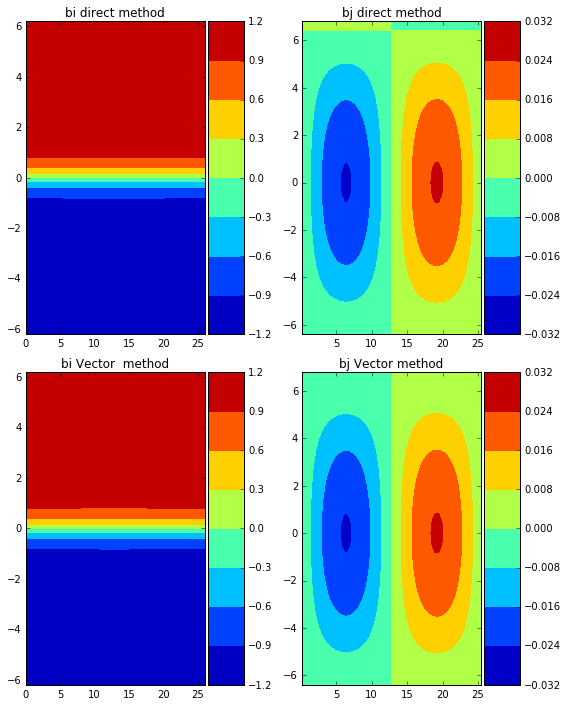

In [98]:
golden_mean = (n.sqrt(5)-1.0)/2.0
figwidth = 8
figheight = 2*figwidth*golden_mean
fig,ax=pl.subplots(nrows=2,ncols=2,figsize=(figwidth,figheight))
cf0 = ax[0,0].contourf(xi[NO2:-NO2+1,NO2:-NO2,4],yi[NO2:-NO2+1,NO2:-NO2,4],
                     bi[NO2:-NO2+1,NO2:-NO2,4])
divider0 = make_axes_locatable(ax[0,0])
cax0 = divider0.append_axes("right", size="20%", pad=0.05)
cbar0 = pl.colorbar(cf0,cax=cax0)
ax[0,0].set_title('bi direct method')
cf1 = ax[0,1].contourf(xj[NO2:-NO2,NO2:-NO2+1,4],yj[NO2:-NO2,NO2:-NO2+1,4],bj[NO2:-NO2,NO2:-NO2+1,4])
ax[0,1].set_title('bj direct method')
divider1 = make_axes_locatable(ax[0,1])
cax1 = divider1.append_axes("right", size="20%", pad=0.05)
cbar1 = pl.colorbar(cf1,cax=cax1)
cf2 = ax[1,0].contourf(xi[NO2:-NO2+1,NO2:-NO2,4],yi[NO2:-NO2+1,NO2:-NO2,4],
                     biFromA[NO2:-NO2+1,NO2:-NO2,4])

divider2 = make_axes_locatable(ax[1,0])
cax2 = divider2.append_axes("right", size="20%", pad=0.05)
cbar2 = pl.colorbar(cf2,cax=cax2)
ax[1,0].set_title('bi Vector  method')
cf3 = ax[1,1].contourf(xj[NO2:-NO2,NO2:-NO2+1,4],yj[NO2:-NO2,NO2:-NO2+1,4],
                     bjFromA[NO2:-NO2,NO2:-NO2+1,4])
ax[1,1].set_title('bj Vector method')
divider3 = make_axes_locatable(ax[1,1])
cax3 = divider3.append_axes("right", size="20%", pad=0.05)
cbar3 = pl.colorbar(cf3,cax=cax3)
pl.tight_layout()